# VAD ET architecture evaluation

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import soundfile as sf
import pickle
from copy import copy
import torch
from vad_et import VadET

In [110]:
# load the model
model = VadET(input_dim=296, hidden_dim=64, num_layers=2, out_dim=3)
model.load_state_dict(torch.load('models/trained_models/vad_et.pt'))

<All keys matched successfully>

In [111]:
FILE = '0_flac/rev1-1116-132851-0008'
with np.load('../data/features/pvad/test/' + FILE + '.pvad.fea.npz') as f:
    x = f['x']
    embed = f['embed']
    y = f['y']
    x = np.hstack((x, np.full((x.shape[0], 256), embed)))

audio, sr = sf.read('../data/concat/' + FILE + '.flac')

new_y = np.kron(y, np.ones(160))
new_x = np.kron(x[:,0] + x[:,1], np.ones(160))

In [112]:
# get the model to generate a label vector for us

conv_filter = np.array([1/8]*8)
conv_filter2 = np.cos([1, 0, -1, 0])

with torch.no_grad():
    x_torch = torch.nn.utils.rnn.pack_padded_sequence(torch.unsqueeze(torch.from_numpy(x).float(), 0),
                                                      torch.tensor([y.size]), batch_first=True)
    
   # y_frame = np.array([])
   # for frame in torch.from_numpy(x).float():
   #     frame_packed = torch.unsqueeze(torch.unsqueeze(frame, 0), 0)
   #     frame_packed = torch.nn.utils.rnn.pack_padded_sequence(frame_packed, torch.tensor([1]), batch_first=True)
   #     out_frame = torch.squeeze(model(frame_packed))
   #     y_frame = np.append(y, torch.argmax(out).numpy())
    
    softmax = torch.nn.Softmax(dim=1)
    output_raw = torch.squeeze(model(x_torch))
    output = torch.argmax(output_raw, dim=1)
    output_raw = softmax(output_raw).numpy()
    o0 = np.kron(output_raw[:, 0], np.ones(160))
    o1 = np.kron(output_raw[:, 1], np.ones(160))
    o2 = np.kron(output_raw[:, 2], np.ones(160))
    
    #output_hard = output_raw > 0.5
    ##output_conv = np.convolve(output_raw, conv_filter)
    #output_conv = np.convolve(np.convolve(output_raw, conv_filter), conv_filter2)
    #output_conv_hard = output_conv > 0.5
    o_raw = np.kron(output, np.ones(160))
    #o_hard = np.kron(output_hard, np.ones(160))
    #o_smooth = np.kron(replace_zero_sequences(output_hard, 8), np.ones(160))
    #o_conv = np.kron(output_conv, np.ones(160))

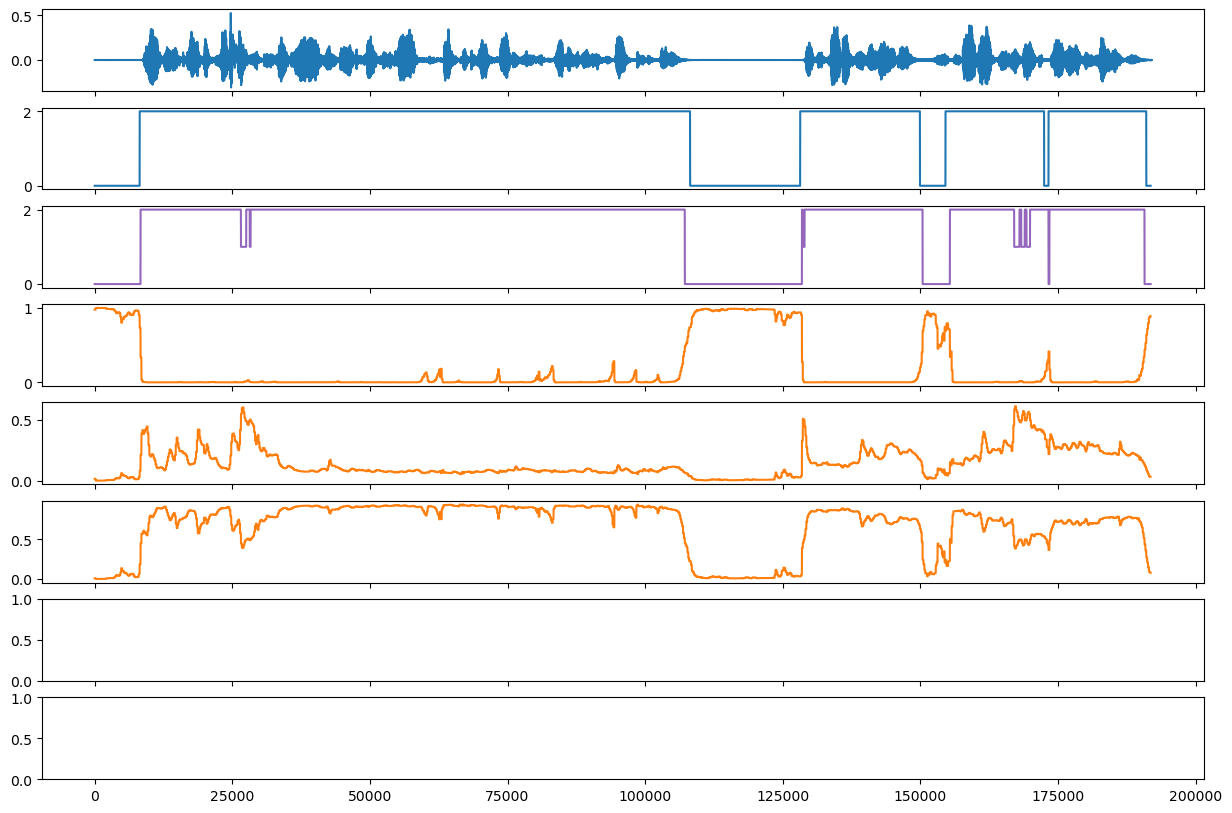

In [113]:
# Plot the original signal and labels plus the first two filterbank coefficients,
# the original shortest sequence and the edited label vector
mpl.style.use('default')
_, ax = plt.subplots(8, 1, figsize=(15,10), sharex=True)
ax[0].plot(audio)
ax[1].plot(new_y)
##ax[2].plot(new_x)
##ax[3].plot(seq)  # plot the position of the shortest sequence
##ax[2].plot(np.kron(replace_zero_sequences(y, 13), np.ones(160))) # deleted super short sequences
ax[2].plot(o_raw, 'C4') # plot the vad prediction
ax[3].plot(o0, 'C1') # plot the vad hard thresholded decision
ax[4].plot(o1, 'C1') # plot the vad hard thresholded decision with short sequences removed
ax[5].plot(o2, 'C1') # plot the vad filtered decision
#ax[6].plot(y_frame) # filtered, thresholded

## mAP evaluation

In [8]:
# first, load the testing dataset and prepare the testing loop
from vad_et import VadETDataset, pad_collate
from vad_set import VadSET, VadSETDataset
from vad_st import VadST, VadSTDataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.metrics import average_precision_score

In [9]:
# load the evaluated model and create the corresponding dataset object
arch = 'set'
batch_size_test = 32

if arch == 'et':
    model = VadET(input_dim=296, hidden_dim=64, num_layers=2, out_dim=3)
    model.load_state_dict(torch.load('models/trained_models/vad_et.pt'))
    test_data = VadETDataset('../data/features/pvad/test')
    
elif arch == 'set':
    model = VadSET(input_dim=297, hidden_dim=64, num_layers=2, out_dim=3)
    model.load_state_dict(torch.load('models/trained_models/vad_set.pt'))
    test_data = VadSETDataset('../data/features/pvad/test')
    
elif arch == 'st':
    model = VadSET(input_dim=41, hidden_dim=64, num_layers=2, out_dim=3)
    model.load_state_dict(torch.load('models/trained_models/vad_st.pt'))
    test_data = VadSTDataset('../data/features/pvad/test')
else:
    # we should not get here
    model = None
    pass

test_loader = DataLoader(
        dataset=test_data, batch_size=batch_size_test, shuffle=False, collate_fn=pad_collate)

In [10]:
# set the device to cuda and move the model to the gpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [61]:
# normal evaluation
with torch.no_grad():
    print("testing...")
    n_correct = 0
    n_samples = 0
    for x_padded, y_padded, x_lens, y_lens in test_loader:
        # pad the sequences..
        x_packed = pack_padded_sequence(
                x_padded, x_lens, batch_first=True, enforce_sorted=False).to(device)

        out_padded = model(x_packed)
        y_padded = y_padded.to(device)

        # value, index
        for j in range(out_padded.size(0)):
            classes = torch.argmax(out_padded[j][:y_lens[j]], dim=1)
            n_samples += y_lens[j]
            n_correct += torch.sum(classes == y_padded[j][:y_lens[j]]).item()

    acc = 100.0 * n_correct / n_samples
    print(f"correctly classified = {acc:.2f}")

testing...
accuracy = 86.40


In [11]:
# mAP evaluation
softmax = torch.nn.Softmax(dim=1)
targets = None
outputs = None

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for x_padded, y_padded, x_lens, y_lens in test_loader:
        # pad the sequences..
        x_packed = pack_padded_sequence(
                x_padded, x_lens, batch_first=True, enforce_sorted=False).to(device)

        out_padded = model(x_packed)
        y_padded = y_padded.to(device)

        # value, index
        for j in range(out_padded.size(0)):
            p = softmax(out_padded[j][:y_lens[j]])
            #p = out_padded[j][:y_lens[j]]
            
            if targets is None:
                outputs = p.cpu().numpy()
                targets = y_padded[j][:y_lens[j]].cpu().numpy()
            else:
                outputs = np.concatenate((outputs, p.cpu().numpy()))
                targets = np.concatenate((targets, y_padded[j][:y_lens[j]].cpu().numpy()))
                
print(targets.shape)
print(outputs.shape)

(5119314,)
(5119314, 3)


In [12]:
# convert the target array to one hot
targets_oh = np.eye(3)[targets]

# and run the AP
out_AP = average_precision_score(targets_oh, outputs, average=None)
mAP = average_precision_score(targets_oh, outputs, average='micro')

print(out_AP) 
print(f"mAP: {mAP}")

[0.94483628 0.98413604 0.98280955]
mAP: 0.9795078337778604
